In [1]:
import numpy as np
import matplotlib as plt
import os 
import timeit
from scipy.stats import uniform

Define help function to compute the total stiffness

In [2]:
def compute_stiffness(w, th , E , l1 , l2 , oe): 
    """
    Inputs:
    w - Beam width
    th - Beam thickness 
    E - Young's modulus of the beam material
    l1 - Length of the longer beams
    l2 - Length of the shorter beams
    oe - Overetch affecting the effective width of the beam

     Output:
     kTotal - Total stiffness of the folded beam structure
    """
    effectiveWidth = w - 2*oe
    J = (1/12) * th * effectiveWidth**3
    #Stiffness of individual beams based on their length
    k1 = 12 * E * J / (l1**3 * 4)
    k2 = 12 * E * J / (l2**3 * 2)
    kTotal = 2 / (1/k1 + 1/k2)
    
    return kTotal


In [3]:
def fringing_coeff( G, W ,L):
    return (1+ G/np.pi/W + G/np.pi/W*np.log(2*np.pi*W/G))*(1+ G/np.pi/L + G/np.pi/L*np.log(2*np.pi*L/G))
    
    

In [4]:
def coarse_model(params):
    """
    - Inputs:
    - parameters[0] : Overetch 
    - parameters[1] : Offset
    - parameters[2] : Thickness

    - Output:
    - C : An array containing the computed difference of capacitance 
    """
    # Time parameters
    t0 = 0                    # Initial time.
    tf = 0.0015-1e-5          # Final time.
    dt =1e-5                  # Time step size.

    # Stiffness parameters
    l1 = 221.4*1e-6              # Lenght of the longer beam 
    l2 = 110*1e-6            # Length of the shorted beam
    E  = 160*1e9               # Young Modulus 
    w  = 2.8*1e-6              # Width 

    # Force parameters 
    phi = lambda t: 0.9*(1-np.cos(2*np.pi*2500*t)) if t < 2/2500 else 0 # Voltage in the right electrodes
    s   = 101*1e-6             # param for the surface 
    dp  =1.2*1e-6                # Distance from the plates with Overetch and Offset = 0 

    # Mass parameters
    rho = 2320                 # Density of the mass.
    A   = 84*1e-9              # Area of the component

    # Damping parameters 
    alpha = 31400            # Damping coefficient alpha.
    beta  =  0               # Damping coeff beta 

    # Input Parameters 
    oe = params[0]*1e-6
    of = params[1]*1e-6
    th = params[2]*1e-6 # ricorda di rimettere 6
   
    eps0 = 8.854*1e-12       # Dielectric permittivity constant
    eps1 = 1.000             # Relative dielectric permittivity of air.

    # Compute the distance between the faces of electrodes and the sensor
    dl = dp+2*oe+of
    dr = dp+2*oe-of
    # Compute the surface of the electrode 
    S = th * (s - 2*oe) * 10  # multiply by ten since we have 10 condensators
    
    # Initial conditions
    u0 = 0  # Initial displacement
    v0 = 0  # Initial velocity
    N = int((tf - t0) / dt)

    # Initialization
    u = np.zeros((N+1))  # displacement
    v = np.zeros((N+1))  # velocity
    C = np.zeros((N+1))  # capacitance
    u[0] = u0
    v[0] = v0
    C[0] = eps1*eps0*S*(1/(dr)*fringing_coeff( dr, s-2*oe ,th) - 1/(dl)*fringing_coeff( dl, s-2*oe ,th))

    # Compute the stiffness
    k = compute_stiffness(w, th , E , l1 , l2 , oe) 
   
    # Compute mass
    m = rho * A * th
    # Compute Damping 
    damp = alpha* m + beta* k

    # Precompute phi values to avoid redundant computation
    k1 =  0.5 * eps0 * eps1 * S
    k2 = eps1*eps0*S
    F_values = np.array([phi(n * dt) for n in range(N)])**2 * k1

    # Time-stepping loop using Forward Euler scheme
    for n in range(N) :
        u_n = u[n]
        v_n = v[n]
        u_new = u_n + dt * v_n
        # Compute the value of the input voltage at time t = n*dt 
        F = F_values[n]/((dr-u_n)**2)
        v[n+1] = v_n + dt * ( F - damp*v_n - k*u_n )/m
        # Compute the difference of capacitance
        C[n+1] = k2*(1/(dr-u_new)*fringing_coeff( dr-u_new, s-2*oe ,th) - 1/(dl+u_new)*fringing_coeff( dl+u_new, s-2*oe ,th))
        u[n+1] = u_new

    return C*1e15

# Compare the model with the exact solutions

Select the true samples on which we want to test the corse model

In [11]:
# Standard library imports
import sys
# Local module imports
sys.path.append('../../src/SurrogateModeling')
sys.path.append('../../src/InverseProblems')
sys.path.append('../../src/utils')
from utils import * 

# Surrogate Model Configurations
CONFIGURATION_I = './config_I.json'
data_processor_I = preprocessing(CONFIGURATION_I)

# Extract test data 
X_values, y_values = data_processor_I.X_test, data_processor_I.y_test

# Which sample of the training set do wou want to take as experimental input?
sample = [11, 22, 38]

# Select a true sample for testing
x_true, y_true = X_values[sample], y_values[sample]
print('        Overetch,   Offset,   Thickness')
x_true


        Overetch,   Offset,   Thickness


array([[ 4.5057900e-01, -4.4200000e-04,  2.9471304e+01],
       [ 1.5078200e-01, -6.1468000e-02,  3.0962383e+01],
       [ 2.6249600e-01, -2.7814000e-02,  2.9626475e+01]])

Perform comparisons with different types of inputs of parameters 

The parameters used are: [ 4.5057900e-01 -4.4200000e-04  2.9471304e+01]


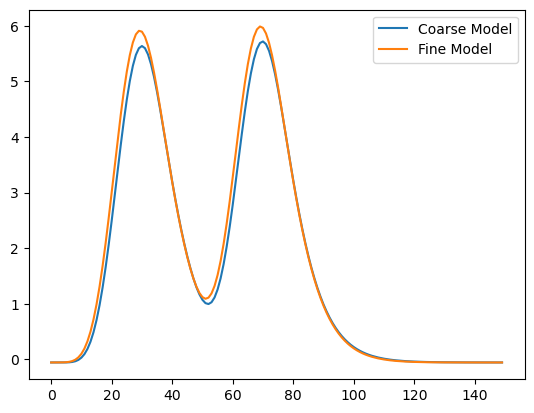

-0.054747561794901145
The parameters used are: [ 0.150782 -0.061468 30.962383]


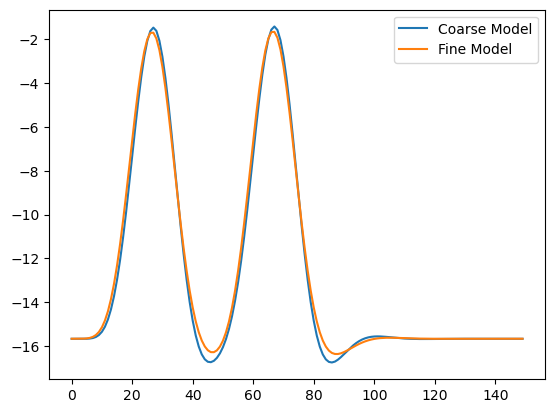

-15.666082549273828
The parameters used are: [ 2.6249600e-01 -2.7814000e-02  2.9626475e+01]


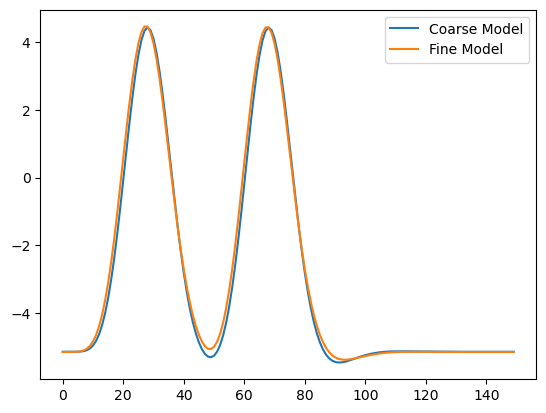

-5.137155182746989
Mean absolute percentage error for the simulations are:
 [0.06298497 0.01891504 0.03884138]


In [15]:
ratio = []
for index, x in enumerate(x_true):
    print('The parameters used are:' , x)
    res = coarse_model(x) * 1.02
    
    plt.plot(res)
    plt.plot(y_true[index])
    plt.legend(['Coarse Model', 'Fine Model'])
    plt.show()
    print(res[0])
    #print(res/y_true[0])
    ratio.append(  np.linalg.norm((res - y_true[index]), ord=1)  / np.linalg.norm(( y_true[index]), ord=1) )


print('Mean absolute percentage error for the simulations are:\n', np.array(ratio) ) 
    

# Compare Coarse and Fine model 


Load fine model 

In [7]:
# Initialize and load model
model_I = NN_Model()
model_I.load_model(data_processor_I.config['MODEL_PATH'])

# Define forward function
forward_model = create_forward_model_function(data_processor_I, model_I)

Compare fine and coarse model on the paramters x

In [9]:
# Define parameters x
X = np.random.uniform(np.array([0.1, -0.5, 29.0]), np.array([0.5, 0.5, 31.0]), size=[1000,3])
# RMB: lower_bound= [0.1, -0.5, 29.0],  upper_bound=[0.5, 0.5, 31.0]

start_time = timeit.default_timer()
res_coarse = [coarse_model(X[i,:]) for i in range(1000)]  
end_time = timeit.default_timer()

res_fine = [forward_model(X[i,:]) for i in range(1000)] 
end_time2 = timeit.default_timer()

print('Time Coarse', end_time-start_time)
print('Time fine', end_time2-end_time)




Time Coarse 1.0155470829922706
Time fine 39.70138041698374


In [ ]:
print(res_coarse.size)

In [ ]:
plt.plot( res_coarse[1,:] )
plt.plot( res_fine[1,:] )
plt.legend(['Coarse model','Fine model' ])
plt.title(('Overetch:', x[0], '  Offset:',x[1], 'Thickness:', x[2]) )
plt.show()